# Investigando o naufrágio do Titanic - 2s2021

## Especialização em Ciência de Dados - IFSP

Catia Tondolo ([@tondoloc](https://github.com/tondoloc)) - CP3013618

Após colidir com um iceberg em 15 de abril de 1912, seu naufrágio matou 1502 pessoas de um total de 2224 passageiros.

Será que alguns grupos de passageiros não tiveram “mais sorte” que outros grupos? Será que crianças e mulheres realmente tiveram mais chances de sobreviver? Será que o Jack teve menos chances de escapar do seu destino trágico que a Rose, só pelo fato de ele ter embarcado na 3ª Classe?

<img src="titanic.jpeg">

### Definição do Problema de Data Science

- análise sobre quais variáveis tiveram maior influência na probabilidade de sobrevivência (ou seja, que tipo de pessoa teve mais chance de escapar com vida).

- após ser capaz de construir um modelo que dê a previsão de sobrevivência para um passageiro qualquer que seja fornecido como input.

### Métrica de Desempenho

O score é calculado em relação ao número de previsões corretas que seu modelo fez. Ou seja, é considerada apenas a acurácia do modelo.

### Dados

Estaõ disponíveis no Kaggle [https://www.kaggle.com/c/titanic/data] e são divididos em treino e teste.

 - Dataset de treino (train.csv)
      - usado para construir o modelo de Machine Learning. Aqui é informado se o passageiro sobreviveu ou não. Possui diversas features como gênero do passageiro e classe do embarque.
 - Dataset de Teste (test.csv)
      - Usado como dados que nunca forma vistos pelo modelo. Aqui não é informado se o passageiro sobreviveu ou não.

As variáveis são:
   - PassengerId: Número de identificação do passageiro
   - Survived: Informa se o passageiro sobreviveu ao desastre
       - 0 = Não
       - 1 = Sim
   - Pclass: Classe do bilhete
       - 1 = 1ª Classe
       - 2 = 2ª Classe
       - 3 = 3ª Classe
   - Name: Nome do passageiro
   - Sex: Sexo do passageiro
   - Age: Idade do passageiro
   - SibSp: Quantidade de cônjuges e irmãos a bordo
   - Parch: Quantidade de pais e filhos a bordo
   - Ticket: Número da passagem
   - Fare: Preço da Passagem
   - Cabin: Número da cabine do passageiro
   - Embarked: Porto no qual o passageiro embarcou
       - C = Cherbourg
       - Q = Queenstown
       - S = Southampton



### Importando bibliotecas


In [145]:
import numpy as np # algebra linear
import pandas as pd # processamento de dados
import seaborn as sns # visualização de dados
import matplotlib.pyplot as plt # gráficos
from collections import Counter
import os

# Modelagem
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, log_loss, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
import xgboost
import warnings
warnings.filterwarnings("ignore")

### Análise exploratória

In [133]:
# Carregando os datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")   

In [126]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [43]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Medidas resumo e distribuição das variáveis

In [44]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [45]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


- os valores para Name são únicos, um para cada pessoa;
- não há missing values para Name e Sex;
- existem apenas os sexos Masculino e Feminino, sendo que o com maior frequência é o Masculino (577/891 = 65%);
- o Porto no qual embarcaram mais passageiros é o de S = Southampton.


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

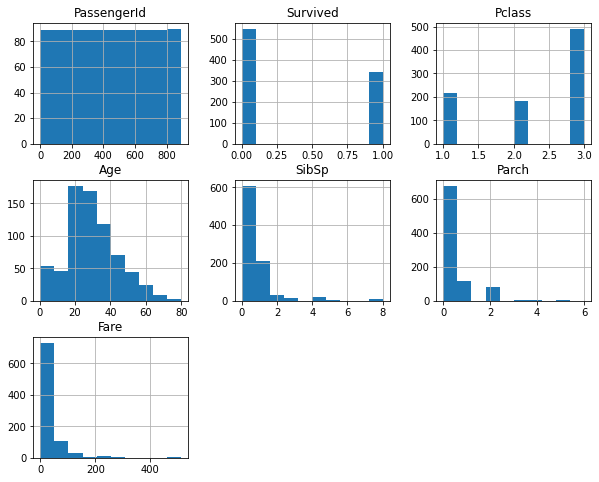

In [46]:
train.hist(figsize=(10,8))

In [47]:
train[['Sex', 'Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


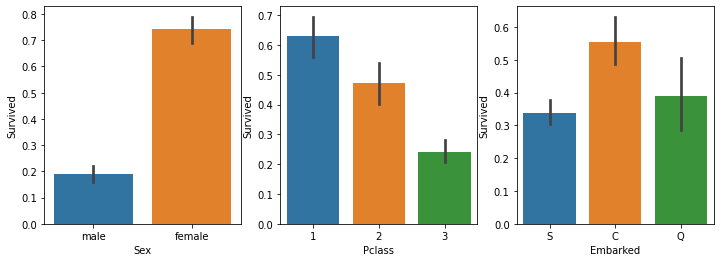

In [48]:
# Plotando os gráficos para Survived vs. Sex, Pclass e Embarked
fig, (axis1, axis2, axis3) = plt.subplots(1,3, figsize=(12,4))

sns.barplot(x='Sex', y='Survived', data=train, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=train, ax=axis2)
sns.barplot(x='Embarked', y='Survived', data=train, ax=axis3);

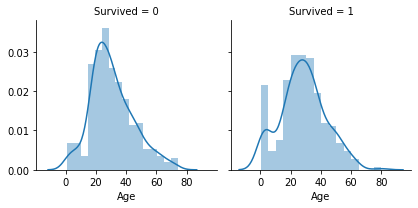

In [49]:
# influência da idade na probabilidade de sobrevivência
age_survived = sns.FacetGrid(train, col='Survived')
age_survived.map(sns.distplot, 'Age')


Text(0.5, 1.0, 'Embarked <-->Survived')

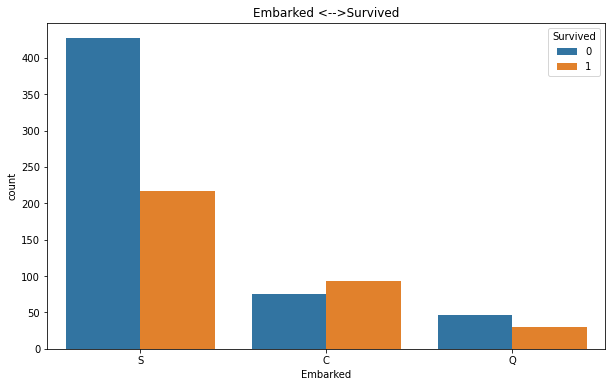

In [127]:
f, ax = plt.subplots(1,1,figsize=(10, 6))
sns.countplot(train.Embarked, hue=train.Survived, ax=ax)
ax.set_title('Embarked <-->Survived')

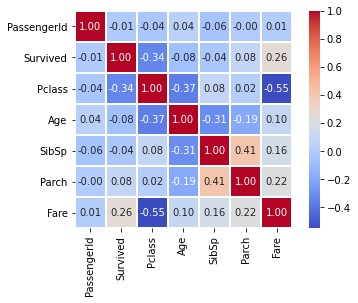

In [50]:
# heatmap para as variáveis numéricas
sns.heatmap(train.corr(), cmap='coolwarm', fmt='.2f', linewidths=0.1,
            vmax=1.0, square=True, linecolor='white', annot=True);

### Feature  engineering

Mergeando os datas sets.

In [134]:
# salvar os índices dos datasets para recuperação posterior
train_idx = train.shape[0]
test_idx = test.shape[0]

# extrair coluna 'Survived' e excluir ela do dataset treino
target = train.Survived.copy()
train.drop(['Survived'], axis=1, inplace=True)

# concatenar treino e teste em um único DataFrame
df_merged = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

print("df_merged.shape: ({} x {})".format(df_merged.shape[0], df_merged.shape[1]))


df_merged.shape: (1309 x 11)


Vou desconsiderar  as variáveis ['PassengerId', 'Name', 'Ticket', 'Cabin']

In [135]:
df_merged.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [136]:
# checando valores faltantes nos datasets de treino e teste
df_merged.isnull().sum()

Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64

- as variáveis idade e tarifa, imputar o valor da mediana, e para a variável do porto de embarque, imputar o valor com maior frequência.


In [137]:
# age
age_median = df_merged['Age'].median()
df_merged['Age'].fillna(age_median, inplace=True)

# fare
fare_median = df_merged['Fare'].median()
df_merged['Fare'].fillna(fare_median, inplace=True)

# embarked
embarked_top = df_merged['Embarked'].value_counts()[0]
df_merged['Embarked'].fillna(embarked_top, inplace=True)

 Modificar:
 - valores possíveis de Sex para {'male': 0, 'female': 1}
 - Embarked variáveis dummies.

In [138]:
# converter 'Sex' em 0 e 1
df_merged['Sex'] = df_merged['Sex'].map({'male': 0, 'female': 1})

# dummie variables para 'Embaked'
embarked_dummies = pd.get_dummies(df_merged['Embarked'], prefix='Embarked')
df_merged = pd.concat([df_merged, embarked_dummies], axis=1)
df_merged.drop('Embarked', axis=1, inplace=True)

display(df_merged.head())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_914,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,0,1


In [139]:
# recuperar datasets de treino e teste
train = df_merged.iloc[:train_idx]
test = df_merged.iloc[train_idx:]

### Modelos

 - Modelo de Regressão Logística
 - Modelo de Árvore de Decisão


In [140]:
# criar um modelo de Regressão Logística
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(train, target)

# verificar a acurácia do modelo
acc_logReg = round(lr_model.score(train, target) * 100, 2)
print("Acurácia Regressão Logística: {}".format(acc_logReg))

Acurácia Regressão Logística: 80.13


Text(33.0, 0.5, 'Prediction')

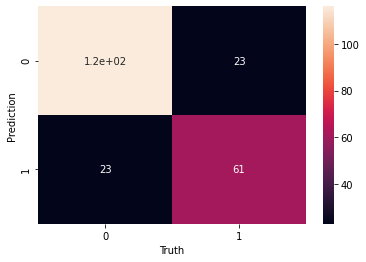

In [143]:
ypred_lr_model=lr_model.predict(X_test)
cm_log=confusion_matrix(y_test,ypred_lr_model)
sns.heatmap(cm_log,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')


In [147]:
print(classification_report(y_test,ypred_lr_model))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       139
           1       0.73      0.73      0.73        84

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



In [149]:
# criar um modelo de árvore de decisão
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(train, target)

# verificar a acurácia do modelo
acc_tree = round(tree_model.score(train, target) * 100, 2)
print("Acurácia Árvore de Decisão: {}".format(acc_tree))

Acurácia Árvore de Decisão: 82.72


Text(33.0, 0.5, 'Prediction')

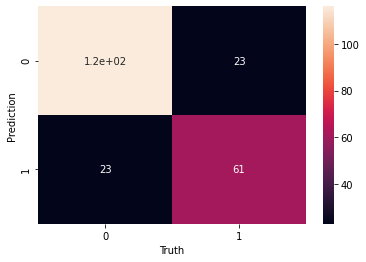

In [153]:
y_pred_tree = tree_model.predict(test)
cm_tree_model=confusion_matrix(y_test,ypred_lr_model)
sns.heatmap(cm_tree_model,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [152]:
# declarar os valores das variáveis para mim e minha esposa
catia_tondolo = np.array([3, 1, 38, 1, 1, 32.2, 0, 0, 0, 1]).reshape((1, -1))

# verificar se nós teríamos sobrevivido
print("Catia Tondolo:\t{}".format(tree_model.predict(catia_tondolo)[0]))


Catia Tondolo:	0


Infelizmente eu não sobreviveria ao desastre do Titanic :'(

### Modelos com GridSearchCV

- KNeighbors
- SVC
- Random Forest
- Decision Tree
- Xgboost

In [185]:
#for hyperparameters

def get_best_params(model, params): 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    search = GridSearchCV(model, params, n_jobs=-1, cv=cv, scoring="accuracy").fit(X_train, y_train)
    best_params = search.best_estimator_.get_params()
    return best_params, search.best_estimator_

In [186]:
def get_score(model): 
    return accuracy_score(y_test, model.predict(X_test))


In [187]:
models = {}

In [188]:
params = {
    'n_neighbors' : list(range(1,5)),
    'weights'     : ['uniform', 'distance'],
    'algorithm'   : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size'   : list(range(1,10)),
    'p'           : [1,2]
}

In [189]:

# Criando objetos
y = target.values
X = train.iloc[:,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### KNeighbors

In [190]:
knn = KNeighborsClassifier()
best_params = get_best_params(knn, params)[0]
best_knn = get_best_params(knn, params)[1]
print(best_params)

{'algorithm': 'ball_tree', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [191]:
models['knn'] = get_score(best_knn)
print(f'{round(get_score(best_knn)*100, 1)} %')


76.2 %


Text(33.0, 0.5, 'Prediction')

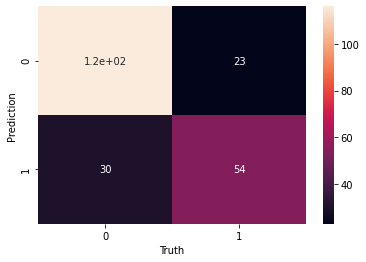

In [192]:
ypred_knn = best_knn.predict(X_test)
cm_knn = confusion_matrix(y_test,ypred_knn)
sns.heatmap(cm_knn,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [193]:
print(classification_report(y_test,ypred_knn))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       139
           1       0.70      0.64      0.67        84

    accuracy                           0.76       223
   macro avg       0.75      0.74      0.74       223
weighted avg       0.76      0.76      0.76       223



#### SVC

In [194]:
params = {
    'C' : [x / 2 for x in range(1,11)],
    'kernel' : ['poly', 'rbf'],
}
svc = SVC()
best_params = get_best_params(svc, params)[0]
best_svc = get_best_params(svc, params)[1]
print(best_params)

{'C': 5.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [195]:
models['svc'] = get_score(best_svc)
print(f'{round(get_score(best_svc)*100, 1)} %')



73.1 %


Text(33.0, 0.5, 'Prediction')

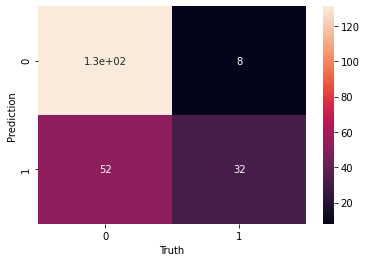

In [196]:
ypred_svc = best_svc.predict(X_test)
cm_svc = confusion_matrix(y_test,ypred_svc)
sns.heatmap(cm_svc,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [197]:
print(classification_report(y_test,ypred_svc))

              precision    recall  f1-score   support

           0       0.72      0.94      0.81       139
           1       0.80      0.38      0.52        84

    accuracy                           0.73       223
   macro avg       0.76      0.66      0.66       223
weighted avg       0.75      0.73      0.70       223



#### Decion Tree

In [198]:
params = {'splitter': ['best', 'random'],
           'max_depth': [7, 8, 9],
           'min_samples_split': [2, 3, 4],
           'min_samples_leaf': [1, 2, 3]}

dt = DecisionTreeClassifier()
best_params = get_best_params(dt, params)[0]
best_dt = get_best_params(dt, params)[1]
print(best_params)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}


In [199]:
models['dt'] = get_score(best_dt)
print(f'{round(get_score(best_dt)*100, 1)} %')

79.4 %


Text(33.0, 0.5, 'Prediction')

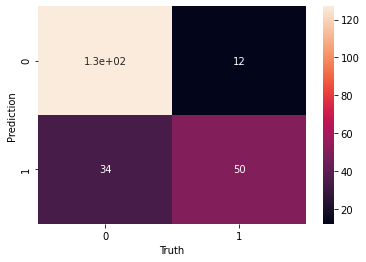

In [200]:
ypred_dt = best_dt.predict(X_test)
cm_dt = confusion_matrix(y_test,ypred_dt)
sns.heatmap(cm_dt,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [201]:
print(classification_report(y_test,ypred_dt))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       139
           1       0.81      0.60      0.68        84

    accuracy                           0.79       223
   macro avg       0.80      0.75      0.77       223
weighted avg       0.80      0.79      0.79       223



#### Random Forest

In [202]:
params = {'n_estimators': [100, 200, 300],
           'max_depth': [7, 8, 9],
           'min_samples_split': [2, 3, 4],
           'min_samples_leaf': [1, 2, 3]}

rfc = RandomForestClassifier()
best_params = get_best_params(rfc, params)[0]
best_rfc = get_best_params(rfc, params)[1]
print(best_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [203]:
models['rfc'] = get_score(best_rfc)
print(f'{round(get_score(best_rfc)*100, 1)} %')

84.8 %


Text(33.0, 0.5, 'Prediction')

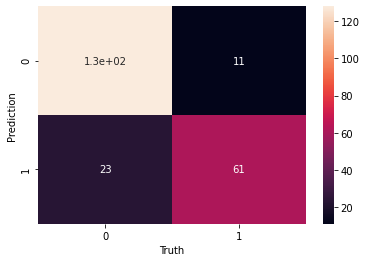

In [204]:
ypred_rfc = best_rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test,ypred_rfc)
sns.heatmap(cm_rfc,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [205]:
print(classification_report(y_test,ypred_rfc))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       139
           1       0.85      0.73      0.78        84

    accuracy                           0.85       223
   macro avg       0.85      0.82      0.83       223
weighted avg       0.85      0.85      0.84       223



#### Xgboost

In [206]:
params = {'learning_rate' : [0.3] ,
          'max_depth': [3], 
          'min_child_weight' : [2, 3]}


xgb = xgboost.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
best_params = get_best_params(xgb, params)[0]
best_xgb = get_best_params(xgb, params)[1]
print(best_params)

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.3, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1, 'use_label_encoder': False, 'eval_metric': 'logloss'}


In [207]:
models['xgb'] = get_score(best_xgb)
print(f'{round(get_score(best_xgb)*100, 1)} %')


84.3 %


Text(33.0, 0.5, 'Prediction')

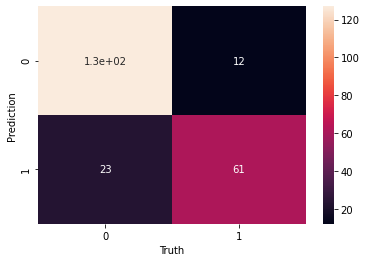

In [208]:
ypred_xgb = best_xgb.predict(X_test)
cm_xgb = confusion_matrix(y_test,ypred_xgb)
sns.heatmap(cm_xgb,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [209]:
print(classification_report(y_test,ypred_xgb))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       139
           1       0.84      0.73      0.78        84

    accuracy                           0.84       223
   macro avg       0.84      0.82      0.83       223
weighted avg       0.84      0.84      0.84       223



#### Regressão Logistica

In [210]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space, 'penalty': ['l1', 'l2']}

rlog = LogisticRegression()
#rlog = GridSearchCV(rlog,param_grid,cv=5)

best_params = get_best_params(rlog, param_grid)[0]
best_rlog = get_best_params(rlog, param_grid)[1]
print(best_params)

{'C': 11787686.347935867, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [211]:
models['rlog'] = get_score(best_rlog)
print(f'{round(get_score(best_rlog)*100, 1)} %')

79.4 %


Text(33.0, 0.5, 'Prediction')

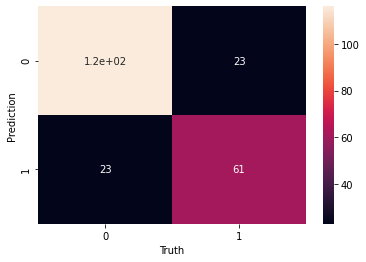

In [212]:
ypred_rlog = best_rlog.predict(X_test)
cm_rlog = confusion_matrix(y_test,ypred_rlog)
sns.heatmap(cm_rlog,annot=True)
plt.xlabel('Truth')
plt.ylabel('Prediction')

In [213]:
print(classification_report(y_test,ypred_rlog))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       139
           1       0.73      0.73      0.73        84

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



### Tabela para visualizar todos os modelos

In [214]:
df_models = pd.DataFrame.from_dict(data = models, orient = "index", columns = ["acc"])
df_models.sort_values(by='acc', ascending = False)



,acc
rfc,0.847534
xgb,0.843049
dt,0.793722
rlog,0.793722
knn,0.762332
svc,0.730942


Comparando os três melhores modelos através do auc roc

In [218]:
roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])

0.8913583418979103

In [219]:
roc_auc_score(y_test, best_xgb.predict(X_test))

0.8199297704693388

In [220]:
roc_auc_score(y_test, best_dt.predict(X_test))

0.7544535799931483